## Imports

In [136]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
virus = "MERS" # "229E" or "MERS"
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK/" + virus

## Data loading and inspection

Create an object with the path to the data.

In [138]:
ca = CellAnalyzer(in_path)

>>> GPU activated? NO


Display the data table.

In [139]:
df, imgs = ca.read_data()
display(df)

7 images loaded


,condition,donor,time,date,sample,replicate,sample_id,mode1,mode2,filename,filepath
0,37mock,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,37mock_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
1,37mock,BEC5,48h,2021-12-22,01,2,BEC5_2,R3D,D3D,37mock_BEC5_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
2,37mock,BEC5,48h,2021-12-22,03,3,BEC5_3,R3D,D3D,37mock_BEC5_48h_21.12.22.03_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
3,37mock,BEC6,48h,2021-12-22,00,1,BEC6_1,R3D,D3D,37mock_BEC6_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
4,MERS,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,MERS_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
5,MERS,BEC5,48h,2021-12-23,00,2,BEC5_2,R3D,D3D,MERS_BEC5_48h_21.12.23_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
6,MERS,BEC6,48h,2021-12-22,01,1,BEC6_1,R3D,D3D,MERS_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...


Check dimensions.

In [140]:
imgs[0].shape

(4, 68, 960, 960)

Create projections.

In [141]:
projections = ca.create_projections(types=["max", "max", "max", "max"]) # Projection options: max, min, mean, median

In [142]:
print(ca.projections[0].shape)
print(ca.projections_types)

(4, 960, 960)
['max', 'max', 'max', 'max']


## Segmentation

In [143]:
# masks, flows, styles, imgs_dn, outlines = ca.segment(channels=[3,1]) # Channels for: Cytoplasm, Nucleus

In [146]:
ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


Check to make sure the data was loaded correctly (hiding the irrelevant columns); after segmentation, the table now includes information about the IDs of the cells in each sample

In [147]:
ca.df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])

,condition,donor,replicate,sample_id,num_cells,cell_id_min,cell_id_max
0,37mock,BEC5,1,BEC5_1,343,1,343
1,37mock,BEC5,2,BEC5_2,306,344,649
2,37mock,BEC5,3,BEC5_3,331,650,980
3,37mock,BEC6,1,BEC6_1,359,981,1339
4,MERS,BEC5,1,BEC5_1,201,1340,1540
5,MERS,BEC5,2,BEC5_2,259,1541,1799
6,MERS,BEC6,1,BEC6_1,334,1800,2133


And we now also have a cells table, which contains the information about the sample plus cell-specific information

In [148]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,inf_mean,cilia_mean_log10,inf_mean_log10,inf_bin,cilia_bin
1200,37mock,BEC6,1,BEC6_1,1201,4685.717466,663.558219,3.670776,2.821879,negative,positive
1201,37mock,BEC6,1,BEC6_1,1202,5267.037348,680.481707,3.721566,2.832816,negative,positive
1202,37mock,BEC6,1,BEC6_1,1203,4266.040141,667.770423,3.630025,2.824627,negative,positive
1203,37mock,BEC6,1,BEC6_1,1204,4862.489869,680.087798,3.686859,2.832565,negative,positive
1204,37mock,BEC6,1,BEC6_1,1205,4480.508189,664.789017,3.651327,2.822684,negative,positive


Save segmentation results, just for viusalization purposes

In [ ]:
ca.save_segmentation_imgs(background_channels=[4,2])

Save the data

In [150]:
# ca.save(overwrite=True)

## Calculate Cell Means

In [152]:
# ca.get_cell_signals({"cilia": 4, "inf": 2}, mode="mean")

In [151]:
ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


We can get the masks with the signal means for each cell

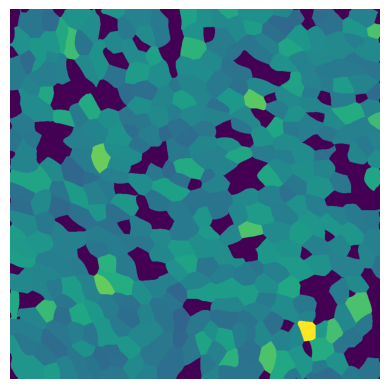

In [153]:
ex_mean_mask = ca.signals_masks["cilia"][3]
plt.imshow(ex_mean_mask)
plt.axis("off")
plt.show()

Save the data

In [154]:
# ca.save(overwrite=True)

## Define threshold and bin cells

In [155]:
ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])

>>> GPU activated? NO
>>> GPU activated? NO


### Infection

In [156]:
mock_inf_log10 = cells_df[cells_df["condition"].str.contains("mock")]["inf_mean_log10"]
inf_log10_thresh = mock_inf_log10.mean() + 3 * mock_inf_log10.std()
inf_log10_thresh_low = mock_inf_log10.mean() + 1.5 * mock_inf_log10.std()
threshs = [inf_log10_thresh, inf_log10_thresh_low]
print(f"Inf log10 thresholds: {inf_log10_thresh_low} | {inf_log10_thresh}")

Inf log10 thresholds: 3.4503381826456954 | 3.886746802411588


In [157]:
ca.get_bins("inf_mean_log10", thresh=threshs, col_name="inf_bin")

In [158]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,inf_mean,cilia_mean_log10,inf_mean_log10,inf_bin,cilia_bin
100,37mock,BEC5,1,BEC5_1,101,8412.242499,787.143876,3.924912,2.896054,negative,positive
101,37mock,BEC5,1,BEC5_1,102,6998.027225,738.749389,3.844976,2.868497,negative,positive
102,37mock,BEC5,1,BEC5_1,103,8252.469059,761.763201,3.916584,2.881820,negative,positive
103,37mock,BEC5,1,BEC5_1,104,7182.439170,734.362422,3.856272,2.865910,negative,positive
104,37mock,BEC5,1,BEC5_1,105,5421.504120,670.012118,3.734120,2.826083,negative,positive


In [159]:
virus_data = cells_df[cells_df["condition"].str.contains(virus)]

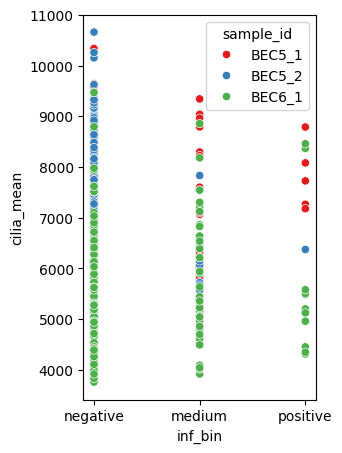

In [160]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=virus_data, x='inf_bin', y='cilia_mean', palette="Set1", hue="sample_id", ax=ax)
plt.show()

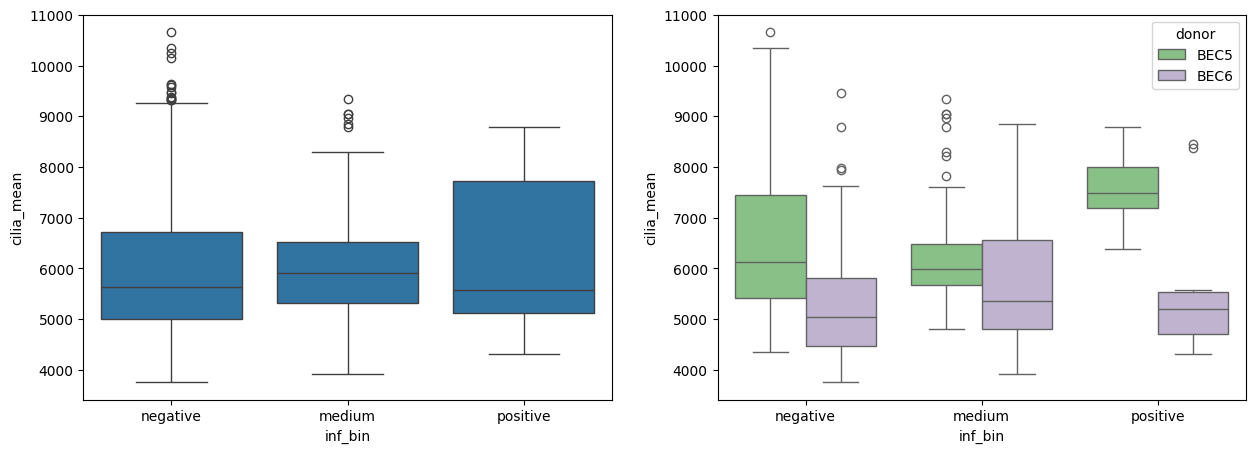

In [161]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
sns.boxplot(data=virus_data, x='inf_bin', y='cilia_mean', ax=ax[0])
sns.boxplot(data=virus_data, x='inf_bin', y='cilia_mean', ax=ax[1], palette="Accent", hue="donor")
plt.show()

### Cilia

In [162]:
ca.get_bins("cilia_mean_log10", thresh=None, col_name="cilia_bin")

Using Otsu's method to find the threshold for cilia_mean_log10: 3.453369860261881


In [163]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,inf_mean,cilia_mean_log10,inf_mean_log10,inf_bin,cilia_bin
100,37mock,BEC5,1,BEC5_1,101,8412.242499,787.143876,3.924912,2.896054,negative,positive
101,37mock,BEC5,1,BEC5_1,102,6998.027225,738.749389,3.844976,2.868497,negative,positive
102,37mock,BEC5,1,BEC5_1,103,8252.469059,761.763201,3.916584,2.881820,negative,positive
103,37mock,BEC5,1,BEC5_1,104,7182.439170,734.362422,3.856272,2.865910,negative,positive
104,37mock,BEC5,1,BEC5_1,105,5421.504120,670.012118,3.734120,2.826083,negative,positive


In [164]:
virus_data = cells_df[cells_df["condition"].str.contains(virus)]

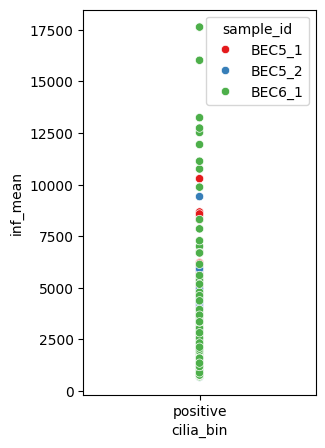

In [165]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=virus_data, x='cilia_bin', y='inf_mean', palette="Set1", hue="sample_id", ax=ax)
plt.show()

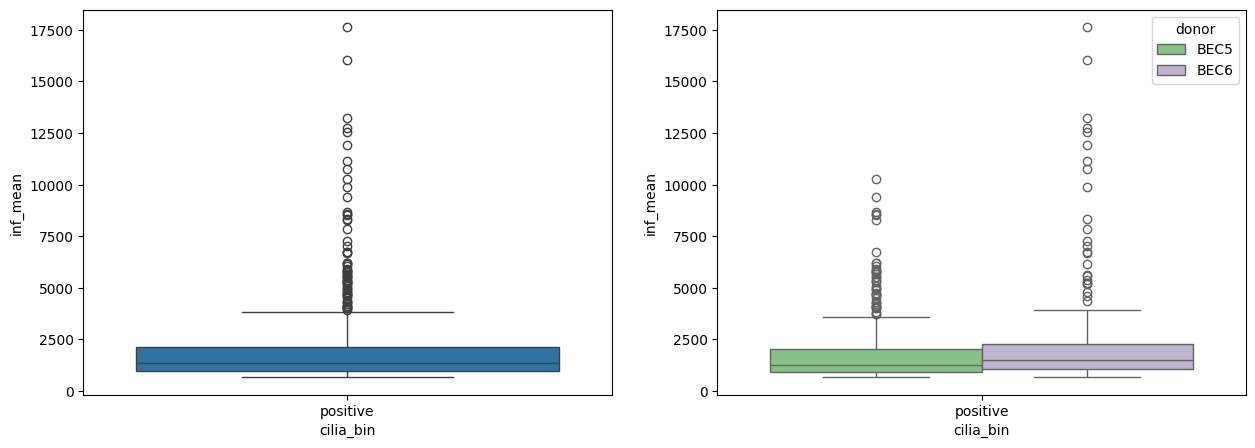

In [166]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
sns.boxplot(data=virus_data, x='cilia_bin', y='inf_mean', ax=ax[0])
sns.boxplot(data=virus_data, x='cilia_bin', y='inf_mean', ax=ax[1], palette="Accent", hue="donor")
plt.show()

### Save the data

In [167]:
ca.save(overwrite=True)